In [4]:
%matplotlib inline
import sys
import xarray as xr
import numpy as np
import os
import glob
import yaml
import math
import scipy
from datetime import datetime, timedelta
from parcels import FieldSet, Field, VectorField, ParticleSet, JITParticle, ParcelsRandom, Variable
import matplotlib.pyplot as plt
from cartopy import crs, feature

sys.path.append('/home/jvalenti/MOAD/analysis-jose/Source')

from OP_functions import *
import cmocean
cmap = cmocean.cm.deep

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [5]:
path = {'NEMO': '/results2/SalishSea/nowcast-green.202111/',
'coords': '/ocean/jvalenti/MOAD/grid/coordinates_seagrid_SalishSea201702.nc',
'coordsWW3': '/ocean/jvalenti/MOAD/grid2/WW3_grid.nc',
'mask': '/ocean/jvalenti/MOAD/grid2/mesh_mask202108_TDV.nc',
'bat': '/ocean/jvalenti/MOAD/grid/bathymetry_202108.nc',
'out': '/data/sallen/results',
'home': '/home/jvalenti/MOAD/analysis-jose/notebooks/parcels',
'anim': '/home/jvalenti/MOAD/animations'}


In [6]:
coords = xr.open_dataset(path['coords'], decode_times=False)
mask = xr.open_dataset(path['mask'])

In [7]:
def get_timestamps(start,length):
    timestamps=[]
    duration = timedelta(days=length)
    for day in range(duration.days):
        timestamps.append([start + timedelta(days=day)])
    return np.array(timestamps, dtype='datetime64')

def find_temp(rootdir):
    dirs=[]
    for file in os.listdir(rootdir):
        d = os.path.join(rootdir, file)
        if os.path.isdir(d):
            dirs.append(d)
    temp=sorted(dirs, key=lambda x: os.path.getctime(x), reverse=True)[:1][0]
    return temp[-12:]

def newest(path):
    files = os.listdir(path)
    paths = [os.path.join(path, basename) for basename in files]
    return max(paths, key=os.path.getctime)


Run for multiple days throughout the year and save output

In [12]:
#Definitions
start = datetime(2022, 11, 23) #Start date
length = 14 # Set Time length [days] 
dt = 90 #toggle between - or + to pick backwards or forwards 
N = 50 # 1000   # number of particles per location
n = 30
dmin = 0 #minimum depth
dd = 100 #max depth difference from dmin
dtp = 0
odt = 1 #mins
rrr = 1e3

In [13]:
#Set deploy coordinates following yaml  
Point_Roberts_j = np.arange(262, 309 + 1) - 1
Point_Roberts_i = 387 - 1
print (coords.nav_lat[Point_Roberts_i, Point_Roberts_j[0]].values,
      coords.nav_lon[Point_Roberts_i, Point_Roberts_j[0]].values,
      coords.nav_lat[Point_Roberts_i, Point_Roberts_j[-1]].values,
      coords.nav_lon[Point_Roberts_i, Point_Roberts_j[-1]].values)

clat = [coords.nav_lat[Point_Roberts_i, Point_Roberts_j[0]].values, 
        coords.nav_lat[Point_Roberts_i, Point_Roberts_j[-1]].values]
clon = [coords.nav_lon[Point_Roberts_i, Point_Roberts_j[0]].values, 
        coords.nav_lon[Point_Roberts_i, Point_Roberts_j[-1]].values]

duration = timedelta(days=length)
#Set deploy locations

clat,clon = transect_deploy(clat,clon,N)
#clon = clon[0] -clon + clon[0]

x_offset, y_offset, z = p_deploy(N,n,dmin,dd,rrr)

lon = np.zeros([N,n])
lat = np.zeros([N,n])
for i in range(N):
    lon[i,:]=(clon[i] + x_offset[i,:])
    lat[i,:]=(clat[i] + y_offset[i,:])

48.88177 -123.32755 48.9709 -123.083115


In [22]:
#Set start date time and the name of the output file
name = 'PR Test mixing vs advection'
daterange = [start+timedelta(days=i) for i in range(length)]
fn =  name + '_'.join(d.strftime('%Y%m%d')+'_1L' for d in [start, start+duration]) + '.zarr'
outfile = os.path.join(path['out'], fn)
outfile

'/data/sallen/results/PR Test mixing vs advection20221123_1L_20221207_1L.zarr'

In [23]:
#Set start date time and the name of the output file
name = 'PR Test only advection '
daterange = [start+timedelta(days=i) for i in range(length)]
fn =  name + '_'.join(d.strftime('%Y%m%d')+'_1L' for d in [start, start+duration]) + '.zarr'
outfile_nomix = os.path.join(path['out'], fn)

In [340]:
####BUILD FIELDS FOR SIMULATION######
local = 0

varlist=['U','V','W']
filenames,variables=filename_set(start,length,varlist)
dimensions = {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw','time': 'time_counter'}
field_set=FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=True, chunksize='auto')

#Find file names and variable names ###'Diat','Flag'###
varlist=['US','VS','WL','R','T','S','ssh','Bathy','Kz','totdepth','Vol']
filenames,variables=filename_set(start,length,varlist)


#Add Vertical diffusivity coefficient field
dimensions = {'lon': 'glamt', 'lat': 'gphit', 'depth': 'depthw','time': 'time_counter'}
Kz = Field.from_netcdf(filenames['Kz'], variables['Kz'], dimensions,allow_time_extrapolation=True, chunksize='auto')
field_set.add_field(Kz)


#Add Bathymetry 2D field
dimensions = {'lon': 'glamt', 'lat': 'gphit'}
Bth = Field.from_netcdf(filenames['Bathy'], variables['Bathy'], dimensions,allow_time_extrapolation=True, chunksize='auto')
TD = Field.from_netcdf(filenames['totdepth'], variables['totdepth'], dimensions,allow_time_extrapolation=True, chunksize='auto')
field_set.add_field(Bth)
field_set.add_field(TD)

#Add SSH 
dimensions = {'lon': 'glamt', 'lat': 'gphit','time': 'time_counter'}
SSH = Field.from_netcdf(filenames['ssh'], variables['ssh'], dimensions,allow_time_extrapolation=True, chunksize='auto')
field_set.add_field(SSH)

####BUILD Particle typeN######
class MPParticle(JITParticle):    
    vvl_factor = Variable('fact', initial =  1)    
    wa = Variable('wa', initial =  0) 
    wm = Variable('wm', initial =  0) 
    status = Variable('status', initial =  1) 

In [341]:
pset = ParticleSet.from_list(field_set, MPParticle, lon=lon, lat=lat, depth=z,time=start+timedelta(hours=odt))
pset2 = ParticleSet.from_list(field_set, MPParticle, lon=lon, lat=lat, depth=z,time=start+timedelta(hours=odt))

In [342]:
def Advection(particle, fieldset, time): 
    if particle.status == 1:
        ssh = fieldset.sossheig[time, particle.depth, particle.lat, particle.lon] #SSH(t)
        sshn = fieldset.sossheig[time+particle.dt, particle.depth, particle.lat, particle.lon] #SSH(t+dt)
        td = fieldset.totaldepth[time, particle.depth, particle.lat, particle.lon]#Total_depth
        particle.fact = (1+ssh/td)
        VVL = (sshn-ssh)*particle.depth/td
        (u1, v1, w1) = fieldset.UVW[time, particle.depth, particle.lat, particle.lon]
        lon1 = particle.lon + u1*.5*particle.dt
        lat1 = particle.lat + v1*.5*particle.dt
        dep1 = particle.depth + w1*.5*particle.dt/particle.fact
        (u2, v2, w2) = fieldset.UVW[time + .5 * particle.dt, dep1, lat1, lon1]
        lon2 = particle.lon + u2*.5*particle.dt
        lat2 = particle.lat + v2*.5*particle.dt
        dep2 = particle.depth + w2*.5*particle.dt/particle.fact
        (u3, v3, w3) = fieldset.UVW[time + .5 * particle.dt, dep2, lat2, lon2]
        lon3 = particle.lon + u3*particle.dt
        lat3 = particle.lat + v3*particle.dt
        dep3 = particle.depth + w3*particle.dt/particle.fact
        (u4, v4, w4) = fieldset.UVW[time + particle.dt, dep3, lat3, lon3]
        wa = (w1 + 2*w2 + 2*w3 + w4) /6.
        particle.wa = wa* particle.dt
        particle_dlon = (u1 + 2*u2 + 2*u3 + u4) / 6. * particle.dt
        particle_dlat = (v1 + 2*v2 + 2*v3 + v4) / 6. * particle.dt
        particle_ddepth = particle.wa/particle.fact + VVL
        if particle_ddepth + particle.depth < 0:
            particle_ddepth = - (particle_ddepth+particle.depth)
    else:
        particle_dlon = 0
        particle_dlat = 0
        particle_ddepth = 0

def turb_mix(particle,fieldset,time):
    if particle.status==1:
        """Vertical mixing"""
        #Vertical mixing
        if particle.depth + 0.5/particle.fact > td: #Only calculate gradient of diffusion for particles deeper than 0.5 otherwise OP will check for particles outside the domain and remove it.
            Kzdz = 2*(fieldset.vert_eddy_diff[time, particle.depth, particle.lat, particle.lon]-fieldset.vert_eddy_diff[time, particle.depth-0.5/particle.fact, particle.lat, particle.lon]) #backwards difference 
        else: 
            Kzdz = 2*(fieldset.vert_eddy_diff[time, particle.depth+0.5/particle.fact, particle.lat, particle.lon]-fieldset.vert_eddy_diff[time, particle.depth, particle.lat, particle.lon]) #forward difference 
        dgrad = Kzdz*particle.dt/particle.fact
        if particle.depth+(0.5*dgrad) > 0 and particle.depth+(0.5*dgrad) < td:
            Kz = fieldset.vert_eddy_diff[time, particle.depth+ 0.5*dgrad, particle.lat, particle.lon] #Vertical diffusivity SSC  
        else:
            Kz = 0#fieldset.vert_eddy_diff[time, particle.depth, particle.lat, particle.lon] 

        Rr = ParcelsRandom.uniform(-1, 1)
        d_random = sqrt(3*2*Kz*particle.dt) * Rr/particle.fact
        dzs = (dgrad + d_random)
        particle.wm = dzs*particle.fact
        

    
def Displacement(particle,fieldset,time):
    '''Apply movement calculated by other kernels'''
    if particle.status==1:
        #Apply turbulent mixing.
        if dzs + particle_ddepth + particle.depth > td: #crossed bottom in dt (Reflect)
            particle_ddepth = 2*td - (dzs + particle_ddepth + 2*particle.depth) #bounce on boundary/ no energy loss
        elif dzs + particle.depth+ particle_ddepth < 0:
            particle_ddepth = -(dzs + particle.depth+particle_ddepth) #reflection on surface
        else:
            particle_ddepth += dzs #apply mixing  

def export(particle,fieldset,time):
    if particle.lat<48.7 and particle.lon < -124.66:
        particle.status = 5

def CheckOutOfBounds(particle, fieldset, time):
    if particle.state == StatusCode.ErrorOutOfBounds:    
        particle.delete()
        
def KeepInOcean(particle, fieldset, time):
    if particle.state == StatusCode.ErrorThroughSurface:
        particle.depth = 0.0
        particle.state = StatusCode.Success

Run both with and without random walk

In [343]:
pset2.execute([Advection,CheckOutOfBounds,export,KeepInOcean],
              runtime=duration, 
              dt=dt,
              output_file=pset2.ParticleFile(name=outfile_nomix, outputdt=timedelta(hours=odt)))

INFO: Output files are stored in /data/sallen/results/PR Test only advection 20221123_3L_20221207_3L.zarr.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1209600.0/1209600.0 [18:22<00:00, 1097.07it/s]


In [344]:
pset.execute([Advection,turb_mix,Displacement,CheckOutOfBounds,export,KeepInOcean],
             runtime=duration, 
             dt=dt,
             output_file=pset.ParticleFile(name=outfile, outputdt=timedelta(hours=odt)))

INFO: Output files are stored in /data/sallen/results/PR Test mixing vs advection20221123_3L_20221207_3L.zarr.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1209600.0/1209600.0 [22:20<00:00, 902.10it/s]


Save and plot repetition one

In [24]:
ds1 = xr.open_zarr(outfile)
advection = np.abs(ds1.wa)
mixing = np.abs(ds1.wm)
pm =mixing/(mixing+advection)
pa= advection/(mixing+advection)

T = np.linspace(0,length*24,int(length*24/odt))
pam = pa.mean(dim='trajectory').values
#pae = pa.std(dim='trajectory').values/np.sqrt(pa.shape[0]) Very small, not worth plotting
depth1 = ds1.z*ds1.fact

ds1_nomix = xr.open_zarr(outfile_nomix)
depth1_nomix = ds1_nomix.z*ds1_nomix.fact

print (outfile, outfile_nomix)


/ocean/sallen/miniconda3/envs/py311_parcels/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


/data/sallen/results/PR Test mixing vs advection20221123_1L_20221207_1L.zarr /data/sallen/results/PR Test only advection 20221123_1L_20221207_1L.zarr


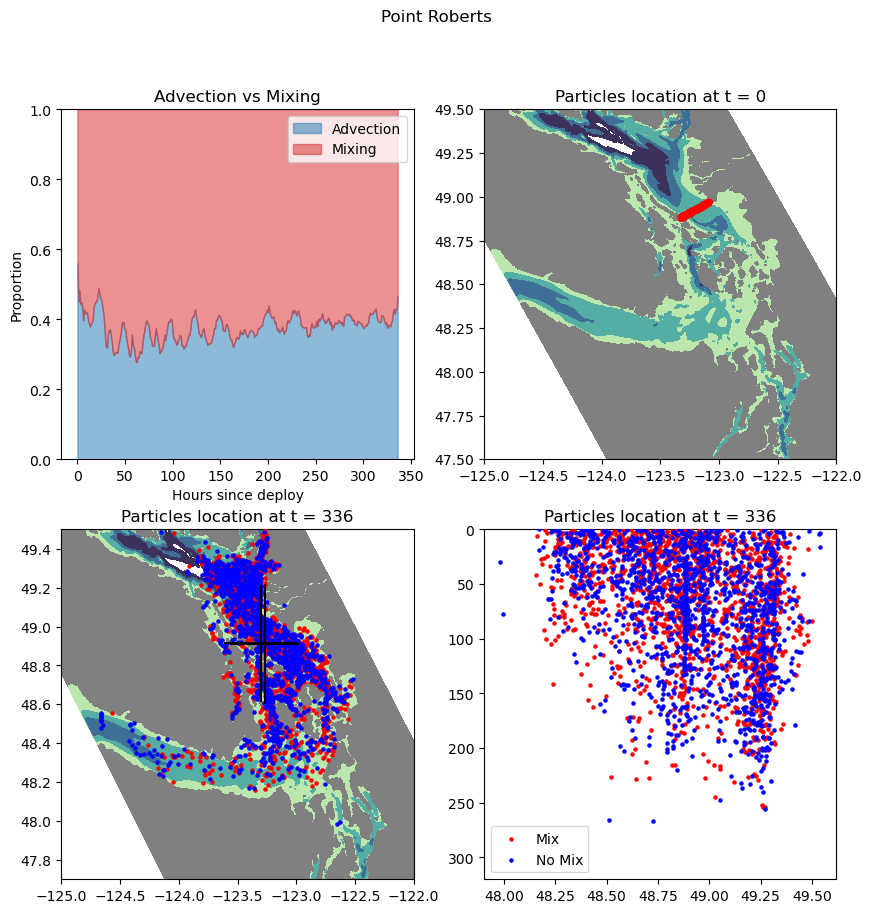

In [25]:
fig,axs=plt.subplots(2,2,figsize=(10,10))
axs[0,0].fill_between(x= T, 
        y1= pam, 
        y2=np.zeros(len(T)),
        color= "tab:blue",
        alpha= 0.5,
        label='Advection')

axs[0,0].fill_between(
        x= T, 
        y1= pam, 
        y2=np.ones(len(T)),
        color= "tab:red",
        alpha= 0.5,
        label='Mixing')
axs[0,0].legend()
axs[0,0].set_title('Advection vs Mixing')
axs[0,0].set_ylim([0,1])
axs[0,0].set_ylabel('Proportion')
axs[0,0].set_xlabel('Hours since deploy')

# Make map
blevels = list(np.arange(0,500,100))

im=axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[0,1].scatter(ds1.lon[:,0],ds1.lat[:,0],zorder=3,c='r',s=5)
axs[0,1].set_ylim([47.5, 49.5])
axs[0,1].set_xlim([-125,-122])
axs[0,1].set_title('Particles location at t = 0')

im=axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[1,0].scatter(ds1.lon[:,-1],ds1.lat[:,-1],zorder=3,c='r',s=5)
axs[1,0].set_ylim([47.7, 49.5])
axs[1,0].set_xlim([-125,-122])
axs[1,0].set_title(f'Particles location at t = {length*24}')
axs[1,0].errorbar(ds1.lon.mean(dim='trajectory')[-1], ds1.lat.mean(dim='trajectory')[-1], yerr= ds1.lat.std(dim='trajectory')[-1], xerr= ds1.lon.std(dim='trajectory')[-1],zorder=5,c='k')

axs[1,1].scatter(ds1.lat[:, -1],depth1[:, -1],zorder=3,c='r',s=5, label='Mix')
axs[1,1].set_ylim([320, 0])
axs[1,1].set_title(f'Particles location at t = {length*24}')
#axs[1,1].errorbar(ds1.lat.mean(dim='trajectory')[-1], depth1.mean(dim='trajectory')[-1], xerr= ds1.lat.std(dim='trajectory')[-1], yerr= depth1.std(dim='trajectory')[-1],zorder=5,c='k')

im=axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[1,0].scatter(ds1_nomix.lon[:,-1],ds1_nomix.lat[:,-1], zorder=3, c='b', s=5)
axs[1,0].set_title(f'Particles location at t = {length*24}')
axs[1,0].errorbar(ds1_nomix.lon.mean(dim='trajectory')[-1], ds1_nomix.lat.mean(dim='trajectory')[-1], yerr= ds1_nomix.lat.std(dim='trajectory')[-1], xerr= ds1_nomix.lon.std(dim='trajectory')[-1],zorder=5,c='k')

axs[1,1].scatter(ds1_nomix.lat[:, -1], depth1_nomix[:, -1], zorder=3, c='b', s=5, label='No Mix')

axs[1,1].legend()
#axs[1, 1].set_xlim([48.87, 49])

fig.suptitle('Point Roberts');


Save and plot repetition two

In [20]:
ds2 = xr.open_zarr(outfile)
advection = np.abs(ds2.wa)
mixing = np.abs(ds2.wm)
pm =mixing/(mixing+advection)
pa= advection/(mixing+advection)

T = np.linspace(0,length*24,int(length*24/odt))
pam = pa.mean(dim='trajectory').values

depth2 = ds2.z*ds2.fact

ds2_nomix = xr.open_zarr(outfile_nomix)
depth2_nomix = ds2_nomix.z*ds2_nomix.fact

/ocean/sallen/miniconda3/envs/py311_parcels/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


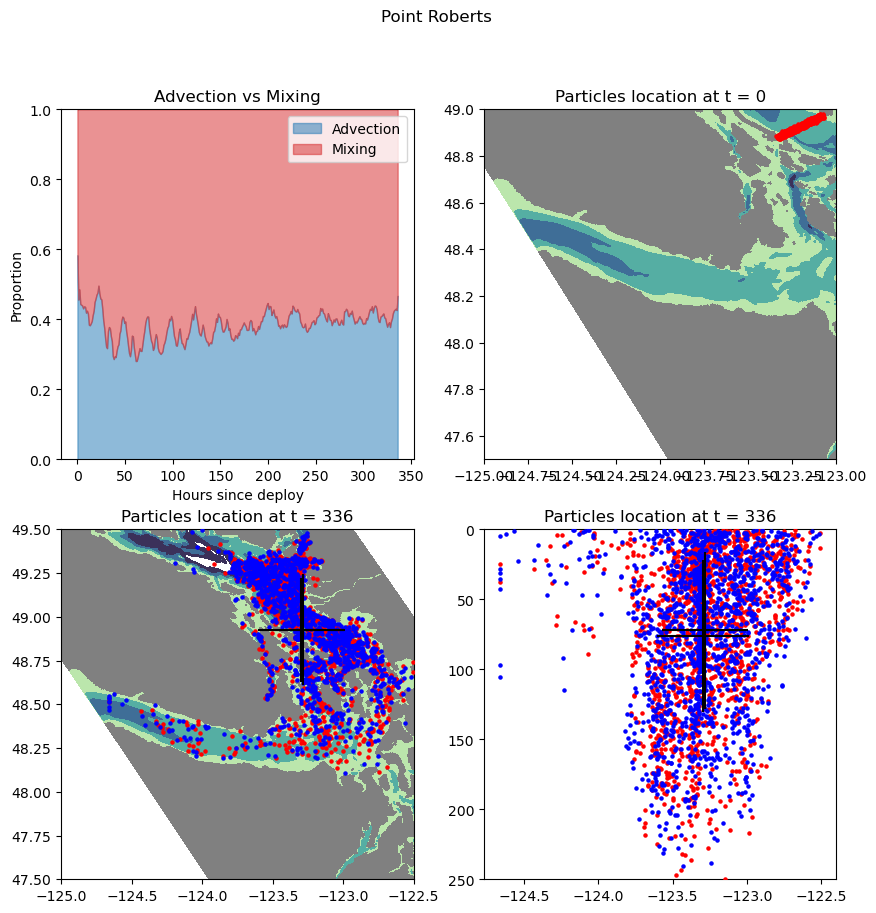

In [21]:
fig,axs=plt.subplots(2,2,figsize=(10,10))
axs[0,0].fill_between(x= T, 
        y1= pam, 
        y2=np.zeros(len(T)),
        color= "tab:blue",
        alpha= 0.5,
        label='Advection')

axs[0,0].fill_between(
        x= T, 
        y1= pam, 
        y2=np.ones(len(T)),
        color= "tab:red",
        alpha= 0.5,
        label='Mixing')
axs[0,0].legend()
axs[0,0].set_title('Advection vs Mixing')
axs[0,0].set_ylim([0,1])
axs[0,0].set_ylabel('Proportion')
axs[0,0].set_xlabel('Hours since deploy')


# Make map
blevels = list(np.arange(0,500,100))

im=axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[0,1].scatter(ds2.lon[:,0],ds2.lat[:,0],zorder=3,c='r',s=5)
axs[0,1].set_ylim([47.5,49])
axs[0,1].set_xlim([-125,-123])
axs[0,1].set_title('Particles location at t = 0')

im=axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[1,0].scatter(ds2.lon[:,-1],ds2.lat[:,-1],zorder=3,c='r',s=5)
axs[1,0].set_ylim([47.5, 49.5])
axs[1,0].set_xlim([-125,-122.5])
axs[1,0].set_title(f'Particles location at t = {length*24}')
axs[1,0].errorbar(ds2.lon.mean(dim='trajectory')[-1], ds2.lat.mean(dim='trajectory')[-1], yerr= ds2.lat.std(dim='trajectory')[-1], xerr= ds2.lon.std(dim='trajectory')[-1],zorder=5,c='k')

axs[1,1].scatter(ds2.lon[:,-1],depth2[:,-1],zorder=3,c='r',s=5)
axs[1,1].set_ylim([250,0])
#axs[1,1].set_xlim([-125,-123])
axs[1,1].set_title(f'Particles location at t = {length*24}')
axs[1,1].errorbar(ds2.lon.mean(dim='trajectory')[-1], depth2.mean(dim='trajectory')[-1], xerr= ds2.lon.std(dim='trajectory')[-1], yerr= depth2.std(dim='trajectory')[-1],zorder=5,c='k')

im=axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[1,0].scatter(ds2_nomix.lon[:,-1],ds2_nomix.lat[:,-1],zorder=3,c='b',s=5)
axs[1,0].set_title(f'Particles location at t = {length*24}')
axs[1,0].errorbar(ds2_nomix.lon.mean(dim='trajectory')[-1], ds2_nomix.lat.mean(dim='trajectory')[-1], yerr= ds2_nomix.lat.std(dim='trajectory')[-1], xerr= ds2_nomix.lon.std(dim='trajectory')[-1],zorder=5,c='k')

axs[1,1].scatter(ds2_nomix.lon[:,-1],depth2_nomix[:,-1],zorder=3,c='b',s=5)
axs[1,1].set_ylim([250,0])
#axs[1,1].set_xlim([-125,-123])
axs[1,1].set_title(f'Particles location at t = {length*24}')
axs[1,1].errorbar(ds2_nomix.lon.mean(dim='trajectory')[-1], depth2_nomix.mean(dim='trajectory')[-1], xerr= ds2_nomix.lon.std(dim='trajectory')[-1], yerr= depth2_nomix.std(dim='trajectory')[-1],zorder=5,c='k')

plt.suptitle('Point Roberts');

Save and plot repetition three

In [16]:
ds3 = xr.open_zarr(outfile)
advection = np.abs(ds3.wa)
mixing = np.abs(ds3.wm)
pm =mixing/(mixing+advection)
pa= advection/(mixing+advection)

T = np.linspace(0,length*24,int(length*24/odt))
pam = pa.mean(dim='trajectory').values
depth3 = ds3.z*ds3.fact

ds3_nomix = xr.open_zarr(outfile_nomix)
depth3_nomix = ds3_nomix.z*ds3_nomix.fact

/ocean/sallen/miniconda3/envs/py311_parcels/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


Text(0.5, 1.0, 'Particles location at t = 336')

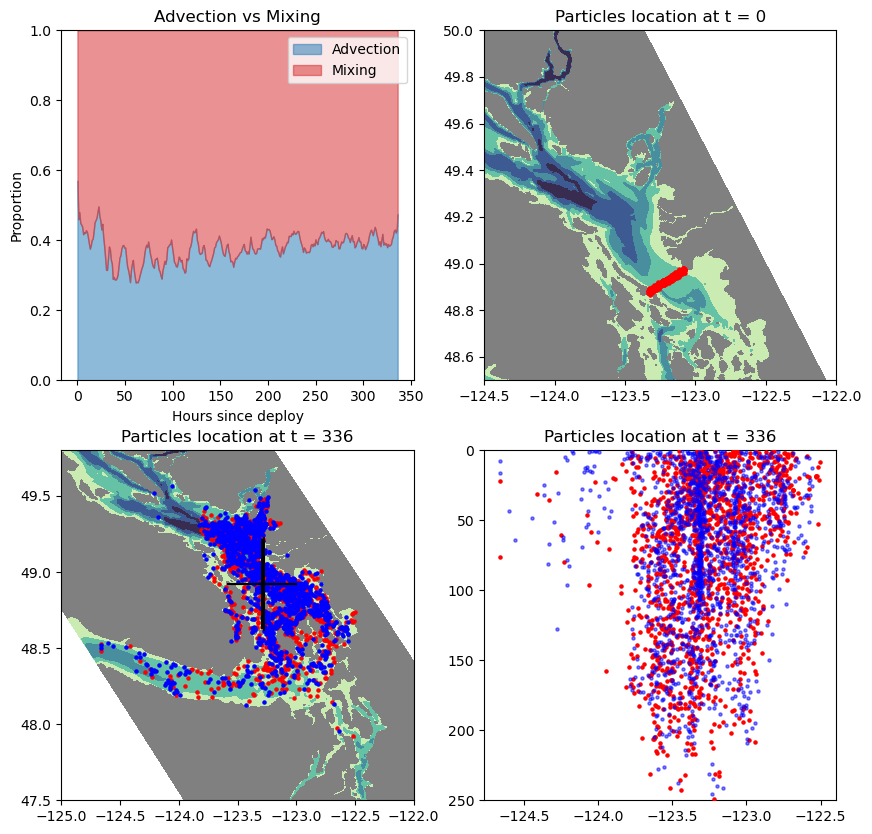

In [17]:
fig,axs=plt.subplots(2,2,figsize=(10,10))
axs[0,0].fill_between(x= T, 
        y1= pam, 
        y2=np.zeros(len(T)),
        color= "tab:blue",
        alpha= 0.5,
        label='Advection')

axs[0,0].fill_between(
        x= T, 
        y1= pam, 
        y2=np.ones(len(T)),
        color= "tab:red",
        alpha= 0.5,
        label='Mixing')
axs[0,0].legend()
axs[0,0].set_title('Advection vs Mixing')
axs[0,0].set_ylim([0,1])
axs[0,0].set_ylabel('Proportion')
axs[0,0].set_xlabel('Hours since deploy')


# Make map
blevels = list(np.arange(0,550,100))

im=axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[0,1].scatter(ds3.lon[:,0],ds3.lat[:,0],zorder=3,c='r',s=5)
axs[0,1].set_ylim([48.5,50])
axs[0,1].set_xlim([-124.5,-122])
axs[0,1].set_title('Particles location at t = 0')

im=axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[1,0].scatter(ds3.lon[:,-1],ds3.lat[:,-1],zorder=3,c='r',s=5)
axs[1,0].set_title(f'Particles location at t = {length*24}')
axs[1,0].errorbar(ds3.lon.mean(dim='trajectory')[-1], ds3.lat.mean(dim='trajectory')[-1], yerr= ds3.lat.std(dim='trajectory')[-1], xerr= ds3.lon.std(dim='trajectory')[-1],zorder=5,c='k')

axs[1,1].scatter(ds3.lon[:,-1], depth3[:,-1],zorder=3,c='r',s=5)
axs[1,1].set_ylim([250,0])
#axs[1,1].errorbar(ds3.lon.mean(dim='trajectory')[-1], depth3.mean(dim='trajectory')[-1], xerr= ds3.lon.std(dim='trajectory')[-1], yerr= depth3.std(dim='trajectory')[-1],zorder=5,c='k')
#axs[1,1].set_xlim([-125,-123])
axs[1,1].set_title(f'Particles location at t = {length*24}')

im=axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[1,0].scatter(ds3_nomix.lon[:,-1],ds3_nomix.lat[:,-1],zorder=3,c='b',s=5)
axs[1,0].set_ylim([47.5, 49.8])
axs[1,0].set_xlim([-125,-122])
axs[1,0].set_title(f'Particles location at t = {length*24}')
axs[1,0].errorbar(ds3_nomix.lon.mean(dim='trajectory')[-1], ds3_nomix.lat.mean(dim='trajectory')[-1], yerr= ds3_nomix.lat.std(dim='trajectory')[-1], xerr= ds3_nomix.lon.std(dim='trajectory')[-1],zorder=5,c='k')

axs[1,1].scatter(ds3_nomix.lon[:,-1],depth3_nomix[:,-1],zorder=3,c='b',s=5, alpha=0.5)
axs[1,1].set_ylim([250,0])
axs[1,1].set_title(f'Particles location at t = {length*24}')
#axs[1,1].errorbar(ds3_nomix.lon.mean(dim='trajectory')[-1], depth3_nomix.mean(dim='trajectory')[-1], xerr= ds3_nomix.lon.std(dim='trajectory')[-1], yerr= depth3_nomix.std(dim='trajectory')[-1],zorder=5,c='k')




### Look at these Three Repetitions
Only considering latitudes south (< 48.8) and not going off to the east (< -122)

/tmp/ipykernel_20121/3669557611.py:5: RuntimeWarning: Mean of empty slice
  axs[0, 0].plot(np.nanmean(lats1, axis=0), label='Full')
/tmp/ipykernel_20121/3669557611.py:7: RuntimeWarning: Mean of empty slice
  axs[0, 0].plot(np.nanmean(lats1_nm, axis=0), label='No subgrid')
/tmp/ipykernel_20121/3669557611.py:13: RuntimeWarning: Mean of empty slice
  axs[1, 0].plot(np.nanmean(lons1, axis=0), label='Full')
/tmp/ipykernel_20121/3669557611.py:15: RuntimeWarning: Mean of empty slice
  axs[1, 0].plot(np.nanmean(lons1_nm, axis=0), label='No subgrid')
/tmp/ipykernel_20121/3669557611.py:56: RuntimeWarning: Mean of empty slice
  axs[3, 0].plot(np.nanmean(lons1, axis=0), np.nanmean(lats1, axis=0), zorder=3, c='y')
/tmp/ipykernel_20121/3669557611.py:57: RuntimeWarning: Mean of empty slice
  axs[3, 0].plot(np.nanmean(lons1_nm, axis=0), np.nanmean(lats1_nm, axis=0), zorder=3, c='m')


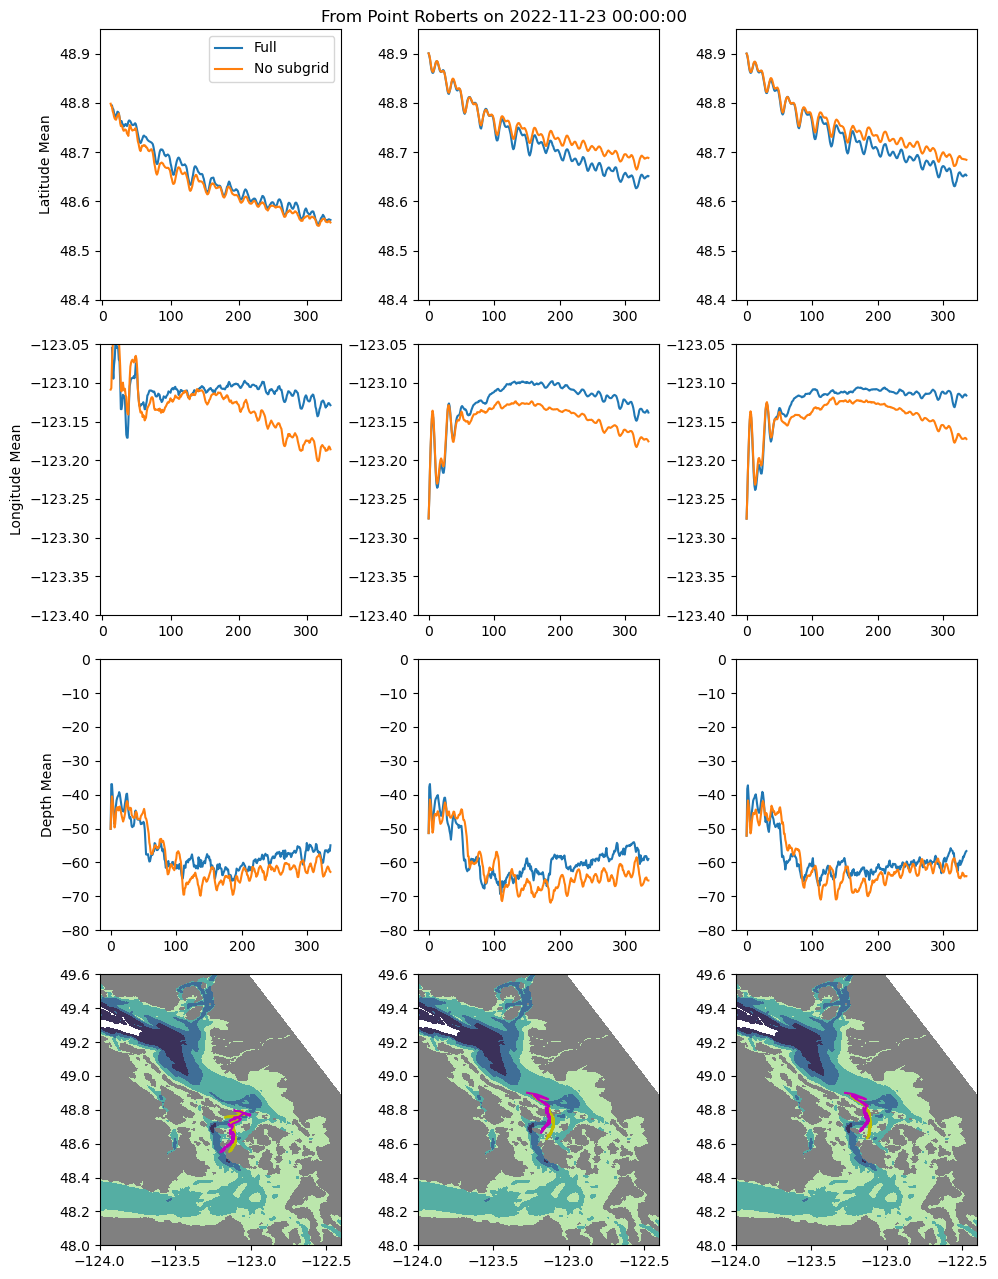

In [26]:
# South Only

fig, axs = plt.subplots(4, 3, figsize=(10, 13))
lats1 = np.array(ds1.lat.where((ds1.lat < 48.8) & (ds1.lon < -122)))
axs[0, 0].plot(np.nanmean(lats1, axis=0), label='Full')
lats1_nm = np.array(ds1_nomix.lat.where((ds1_nomix.lat < 48.8) & (ds1_nomix.lon < -122)))
axs[0, 0].plot(np.nanmean(lats1_nm, axis=0), label='No subgrid')

axs[0, 0].legend();
axs[0, 0].set_ylabel('Latitude Mean');

lons1 = np.array(ds1.lon.where((ds1.lat < 48.8) & (ds1.lon < -122)))
axs[1, 0].plot(np.nanmean(lons1, axis=0), label='Full')
lons1_nm = np.array(ds1_nomix.lon.where((ds1_nomix.lat < 48.8) & (ds1_nomix.lon < -122)))
axs[1, 0].plot(np.nanmean(lons1_nm, axis=0), label='No subgrid')
#print ('Lon 1', np.nanmean(lons1, axis=0)[-1], np.nanmean(lons1_nm, axis=0)[-1])
axs[1, 0].set_ylabel('Longitude Mean');

depth1n = -np.array(depth1.where(ds1.lat < 48.92))
axs[2, 0].plot(np.nanmean(depth1n, axis=0), label='Full')
depth1_nm = -np.array(depth1_nomix.where(ds1_nomix.lat < 48.92))
axs[2, 0].plot(np.nanmean(depth1_nm, axis=0), label='No subgrid')
#print ('depth 1', np.nanmean(depth1n, axis=0)[-1], np.nanmean(depth1_nm, axis=0)[-1])
axs[2, 0].set_ylabel('Depth Mean');

lats2 = np.array(ds2.lat.where(ds2.lat < 48.92))
axs[0, 1].plot(np.nanmean(lats2, axis=0), label='Full')
lats2_nm = np.array(ds2_nomix.lat.where(ds2_nomix.lat < 48.92))
axs[0, 1].plot(np.nanmean(lats2_nm, axis=0), label='No subgrid')

lons2 = np.array(ds2.lon.where(ds2.lat < 48.92))
axs[1, 1].plot(np.nanmean(lons2, axis=0), label='Full')
lons2_nm = np.array(ds2_nomix.lon.where(ds2_nomix.lat < 48.92))
axs[1, 1].plot(np.nanmean(lons2_nm, axis=0), label='No subgrid')

depth2n = -np.array(depth2.where(ds2.lat < 48.92))
axs[2, 1].plot(np.nanmean(depth2n, axis=0), label='Full')
depth2_nm = -np.array(depth2_nomix.where(ds2_nomix.lat < 48.92))
axs[2, 1].plot(np.nanmean(depth2_nm, axis=0), label='No subgrid')

lats3 = np.array(ds3.lat.where(ds3.lat < 48.92))
axs[0, 2].plot(np.nanmean(lats3, axis=0), label='Full')
lats3_nm = np.array(ds3_nomix.lat.where(ds3_nomix.lat < 48.92))
axs[0, 2].plot(np.nanmean(lats3_nm, axis=0), label='No subgrid')

lons3 = np.array(ds3.lon.where(ds3.lat < 48.92))
axs[1, 2].plot(np.nanmean(lons3, axis=0), label='Full')
lons3_nm = np.array(ds3_nomix.lon.where(ds3_nomix.lat < 48.92))
axs[1, 2].plot(np.nanmean(lons3_nm, axis=0), label='No subgrid')

depth3n = -np.array(depth3.where(ds3.lat < 48.92))
axs[2, 2].plot(np.nanmean(depth3n, axis=0), label='Full')
depth3_nm = -np.array(depth3_nomix.where(ds3_nomix.lat < 48.92))
axs[2, 2].plot(np.nanmean(depth3_nm, axis=0), label='No subgrid')

axs[3, 0].plot(np.nanmean(lons1, axis=0), np.nanmean(lats1, axis=0), zorder=3, c='y')
axs[3, 0].plot(np.nanmean(lons1_nm, axis=0), np.nanmean(lats1_nm, axis=0), zorder=3, c='m')

axs[3, 1].plot(np.nanmean(lons2, axis=0), np.nanmean(lats2, axis=0), zorder=3, c='y')
axs[3, 1].plot(np.nanmean(lons2_nm, axis=0), np.nanmean(lats2_nm, axis=0), zorder=3, c='m')

axs[3, 2].plot(np.nanmean(lons3, axis=0), np.nanmean(lats3, axis=0), zorder=3, c='y')
axs[3, 2].plot(np.nanmean(lons3_nm, axis=0), np.nanmean(lats3_nm, axis=0), zorder=3, c='m')


for ax in axs[0]:
    ax.set_ylim(48.4, 48.95)
for ax in axs[1]:
    ax.set_ylim(-123.4, -123.05)
for ax in axs[2]:
    ax.set_ylim(-80, 0)
for ax in axs[3]:
#    ax.set_ylim(48.6, 48.95)
    ax.set_ylim(48, 49.6)
#    ax.set_xlim(-123.4, -123.05)
    ax.set_xlim(-124, -122.4)
    im=ax.contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:], zorder=1, cmap=cmap, levels=blevels)
    ax.contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:], zorder=2, cmap='gray', levels=[-1,0])

fig.suptitle(f'From Point Roberts on {start}')
fig.tight_layout();

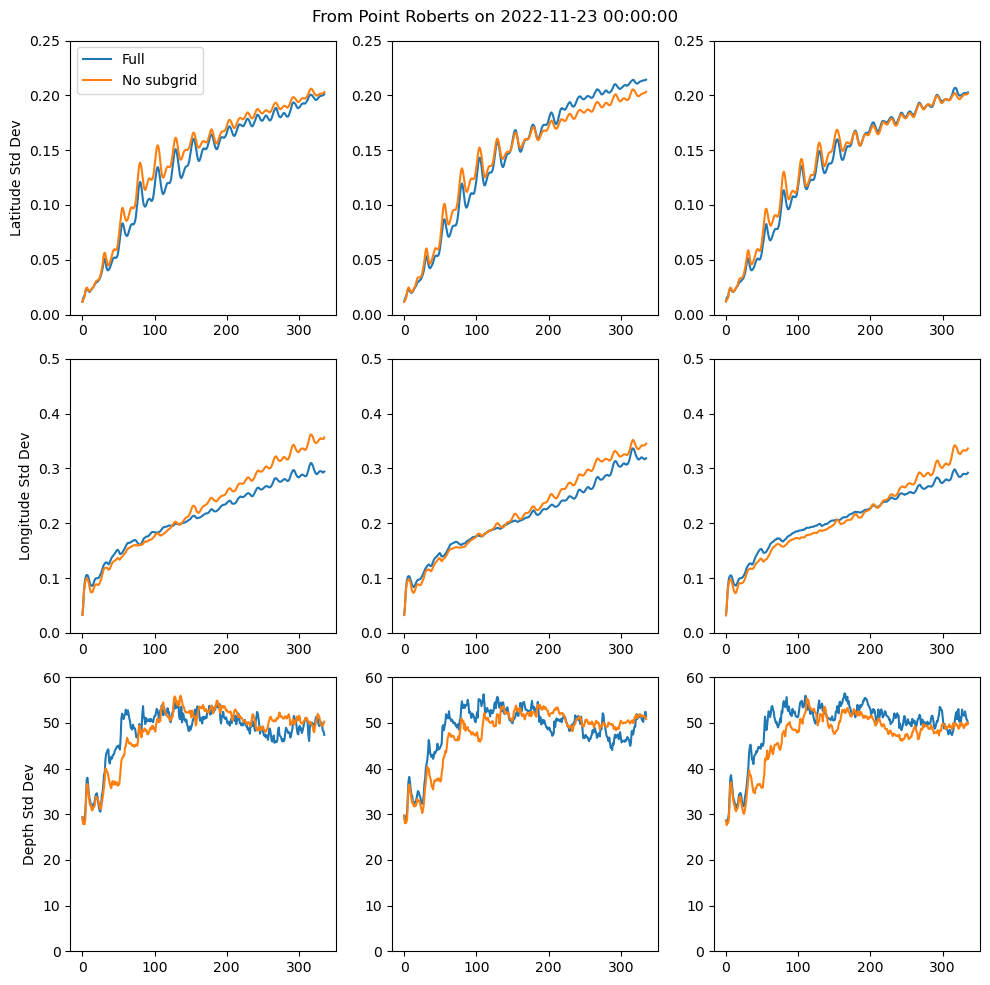

In [27]:
# South Only
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
lats1 = np.array(ds1.lat.where(ds1.lat < 48.92))
axs[0, 0].plot(np.nanstd(lats1, axis=0), label='Full')
lats1_nm = np.array(ds1_nomix.lat.where(ds1_nomix.lat < 48.92))
axs[0, 0].plot(np.nanstd(lats1_nm, axis=0), label='No subgrid')

axs[0, 0].legend();
axs[0, 0].set_ylabel('Latitude Std Dev');

lons1 = np.array(ds1.lon.where(ds1.lat < 48.92))
axs[1, 0].plot(np.nanstd(lons1, axis=0), label='Full')
lons1_nm = np.array(ds1_nomix.lon.where(ds1_nomix.lat < 48.92))
axs[1, 0].plot(np.nanstd(lons1_nm, axis=0), label='No subgrid')
axs[1, 0].set_ylabel('Longitude Std Dev');

depth1n = -np.array(depth1.where(ds1.lat < 48.92))
axs[2, 0].plot(np.nanstd(depth1n, axis=0), label='Full')
depth1_nm = -np.array(depth1_nomix.where(ds1_nomix.lat < 48.92))
axs[2, 0].plot(np.nanstd(depth1_nm, axis=0), label='No subgrid')
axs[2, 0].set_ylabel('Depth Std Dev');

lats2 = np.array(ds2.lat.where(ds2.lat < 48.92))
axs[0, 1].plot(np.nanstd(lats2, axis=0), label='Full')
lats2_nm = np.array(ds2_nomix.lat.where(ds2_nomix.lat < 48.92))
axs[0, 1].plot(np.nanstd(lats2_nm, axis=0), label='No subgrid')

lons2 = np.array(ds2.lon.where(ds2.lat < 48.92))
axs[1, 1].plot(np.nanstd(lons2, axis=0), label='Full')
lons2_nm = np.array(ds2_nomix.lon.where(ds2_nomix.lat < 48.92))
axs[1, 1].plot(np.nanstd(lons2_nm, axis=0), label='No subgrid')

depth2n = -np.array(depth2.where(ds2.lat < 48.92))
axs[2, 1].plot(np.nanstd(depth2n, axis=0), label='Full')
depth2_nm = -np.array(depth2_nomix.where(ds2_nomix.lat < 48.92))
axs[2, 1].plot(np.nanstd(depth2_nm, axis=0), label='No subgrid')

lats3 = np.array(ds3.lat.where(ds3.lat < 48.92))
axs[0, 2].plot(np.nanstd(lats3, axis=0), label='Full')
lats3_nm = np.array(ds3_nomix.lat.where(ds3_nomix.lat < 48.92))
axs[0, 2].plot(np.nanstd(lats3_nm, axis=0), label='No subgrid')

lons3 = np.array(ds3.lon.where(ds3.lat < 48.92))
axs[1, 2].plot(np.nanstd(lons3, axis=0), label='Full')
lons3_nm = np.array(ds3_nomix.lon.where(ds3_nomix.lat < 48.92))
axs[1, 2].plot(np.nanstd(lons3_nm, axis=0), label='No subgrid')

depth3n = -np.array(depth3.where(ds3.lat < 48.92))
axs[2, 2].plot(np.nanstd(depth3n, axis=0), label='Full')
depth3_nm = -np.array(depth3_nomix.where(ds3_nomix.lat < 48.92))
axs[2, 2].plot(np.nanstd(depth3_nm, axis=0), label='No subgrid')

for ax in axs[0]:
    ax.set_ylim(0, 0.25)
for ax in axs[1]:
    ax.set_ylim(0, 0.5)
for ax in axs[2]:
    ax.set_ylim(0, 60)

fig.suptitle(f'From Point Roberts on {start}')
fig.tight_layout();

## Analyze All Runs
Read them back in and analysis all together (4 dates, 3 runs each)

### Plot the longitude of all parcels and the mean longitude (south particles < 48.92)

/data/sallen/results/PR Test mixing vs advection20220223_1L_20220309_1L.zarr
/data/sallen/results/PR Test mixing vs advection20220223_2L_20220309_2L.zarr
/data/sallen/results/PR Test mixing vs advection20220223_3L_20220309_3L.zarr
/data/sallen/results/PR Test mixing vs advection20220523_1L_20220606_1L.zarr
/data/sallen/results/PR Test mixing vs advection20220523_2L_20220606_2L.zarr
/data/sallen/results/PR Test mixing vs advection20220523_3L_20220606_3L.zarr
/data/sallen/results/PR Test mixing vs advection20220823_1L_20220906_1L.zarr
/data/sallen/results/PR Test mixing vs advection20220823_2L_20220906_2L.zarr
/data/sallen/results/PR Test mixing vs advection20220823_3L_20220906_3L.zarr
/data/sallen/results/PR Test mixing vs advection20221123_1L_20221207_1L.zarr
/data/sallen/results/PR Test mixing vs advection20221123_2L_20221207_2L.zarr
/data/sallen/results/PR Test mixing vs advection20221123_3L_20221207_3L.zarr


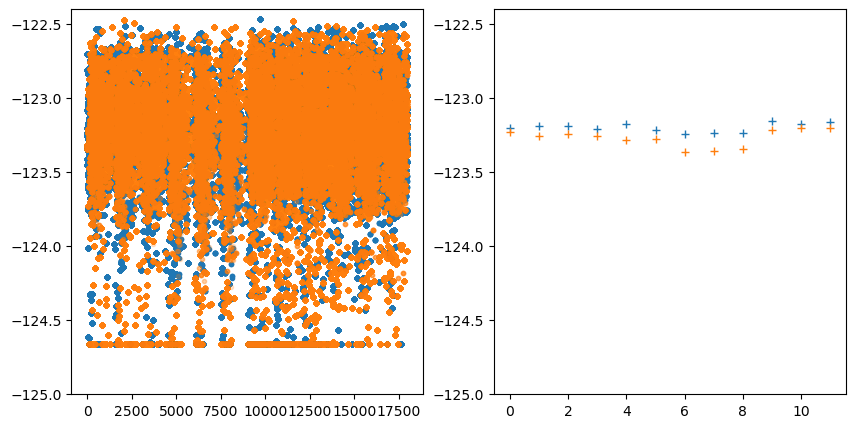

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

lon_mix = np.zeros(12)
lon_nomix = np.zeros(12)
max_lon = np.zeros(12)
max_lon_nomix = np.zeros(12)

name = 'PR Test mixing vs advection'
#daterange = [start+timedelta(days=i) for i in range(length)]
#fn =  name + '_'.join(d.strftime('%Y%m%d')+'_2L' for d in [start, start+duration]) + '.zarr'
for ii, fn in enumerate(sorted(glob.glob(os.path.join(path['out'], name + '*_[123]L*')))):
    print (fn)
    data = xr.open_zarr(fn)
    axs[0].plot(range(ii*1500, 1500*(1+ii)), data.lon[:,-1].where(data.lat < 48.92), '.', c='tab:blue')
    axs[1].plot(ii, np.nanmean(data.lon[:,-1].where(data.lat < 48.92)), '+', c='tab:blue')
    values = np.nanmean(data.lon[:, :].where(data.lat < 48.92), axis=0)
    lon_mix[ii] = values[-1] # np.nanmean(data.lon[:,-1].where(data.lat < 48.92))
    max_lon[ii] = np.nanmax(values)

    data.close()

name = 'PR Test only advection '
for ii, fn in enumerate(sorted(glob.glob(os.path.join(path['out'], name + '*_[123]L*')))):
    data = xr.open_zarr(fn)
    axs[0].plot(range(ii*1500, 1500*(1+ii)), data.lon[:,-1].where(data.lat < 48.92), '.', c='tab:orange', alpha=0.2)
    axs[1].plot(ii, np.nanmean(data.lon[:,-1].where(data.lat < 48.92)), '+', c='tab:orange')
    values = np.nanmean(data.lon[:, :].where(data.lat < 48.92), axis=0)
    lon_nomix[ii] = values[-1]
    max_lon_nomix[ii] = np.nanmax(values)

    data.close()
    



for ax in axs:
    ax.set_ylim(-125, -122.4)



### Same for latitude: Plot the latitude of all parcels and the mean latitude (south particles < 48.92)

/data/sallen/results/PR Test mixing vs advection20220223_1L_20220309_1L.zarr
/data/sallen/results/PR Test mixing vs advection20220223_2L_20220309_2L.zarr
/data/sallen/results/PR Test mixing vs advection20220223_3L_20220309_3L.zarr
/data/sallen/results/PR Test mixing vs advection20220523_1L_20220606_1L.zarr
/data/sallen/results/PR Test mixing vs advection20220523_2L_20220606_2L.zarr
/data/sallen/results/PR Test mixing vs advection20220523_3L_20220606_3L.zarr
/data/sallen/results/PR Test mixing vs advection20220823_1L_20220906_1L.zarr
/data/sallen/results/PR Test mixing vs advection20220823_2L_20220906_2L.zarr
/data/sallen/results/PR Test mixing vs advection20220823_3L_20220906_3L.zarr
/data/sallen/results/PR Test mixing vs advection20221123_1L_20221207_1L.zarr
/data/sallen/results/PR Test mixing vs advection20221123_2L_20221207_2L.zarr
/data/sallen/results/PR Test mixing vs advection20221123_3L_20221207_3L.zarr


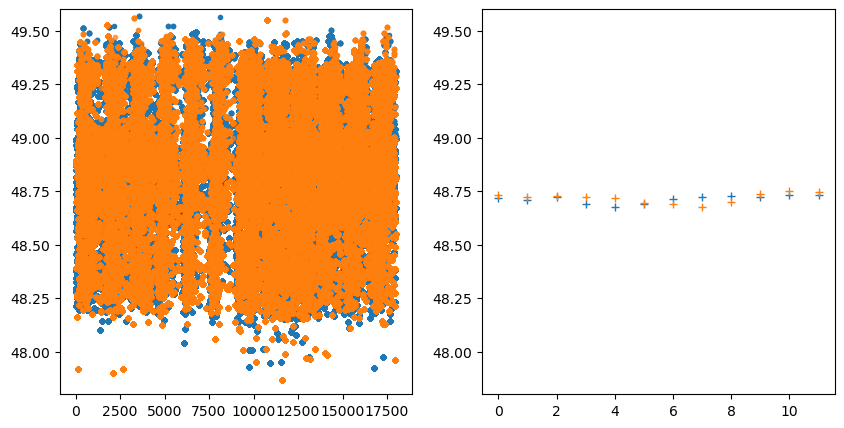

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

keep_mix = np.zeros(12)
keep_nomix = np.zeros(12)


name = 'PR Test mixing vs advection'
#daterange = [start+timedelta(days=i) for i in range(length)]
#fn =  name + '_'.join(d.strftime('%Y%m%d')+'_2L' for d in [start, start+duration]) + '.zarr'
for ii, fn in enumerate(sorted(glob.glob(os.path.join(path['out'], name + '*_[123]L*')))):
    print (fn)
    data = xr.open_zarr(fn)
    axs[0].plot(range(ii*1500, 1500*(1+ii)), data.lat[:,-1].where(data.lat < 48.92), '.', c='tab:blue')
    axs[1].plot(ii, np.nanmean(data.lat[:,-1].where(data.lat < 48.92)), '+', c='tab:blue')
    keep_mix[ii] = np.nanmean(data.lat[:,-1].where(data.lat < 48.92))
    data.close()

name = 'PR Test only advection '
for ii, fn in enumerate(sorted(glob.glob(os.path.join(path['out'], name + '*_[123]L*')))):
    data = xr.open_zarr(fn)
    axs[0].plot(range(ii*1500, 1500*(1+ii)), data.lat[:,-1].where(data.lat < 48.92), '.', c='tab:orange', alpha=0.7)
    axs[1].plot(ii, np.nanmean(data.lat[:,-1].where(data.lat < 48.92)), '+', c='tab:orange')
    keep_nomix[ii] = np.nanmean(data.lat[:,-1].where(data.lat < 48.92))
    data.close()
    



for ax in axs:
    ax.set_ylim(47.8, 49.6)

### Same for depth: Plot the depth of all parcels and the mean depth (south particles < 48.92)

/data/sallen/results/PR Test mixing vs advection20220223_1L_20220309_1L.zarr
/data/sallen/results/PR Test mixing vs advection20220223_2L_20220309_2L.zarr
/data/sallen/results/PR Test mixing vs advection20220223_3L_20220309_3L.zarr
/data/sallen/results/PR Test mixing vs advection20220523_1L_20220606_1L.zarr
/data/sallen/results/PR Test mixing vs advection20220523_2L_20220606_2L.zarr
/data/sallen/results/PR Test mixing vs advection20220523_3L_20220606_3L.zarr
/data/sallen/results/PR Test mixing vs advection20220823_1L_20220906_1L.zarr
/data/sallen/results/PR Test mixing vs advection20220823_2L_20220906_2L.zarr
/data/sallen/results/PR Test mixing vs advection20220823_3L_20220906_3L.zarr
/data/sallen/results/PR Test mixing vs advection20221123_1L_20221207_1L.zarr
/data/sallen/results/PR Test mixing vs advection20221123_2L_20221207_2L.zarr
/data/sallen/results/PR Test mixing vs advection20221123_3L_20221207_3L.zarr


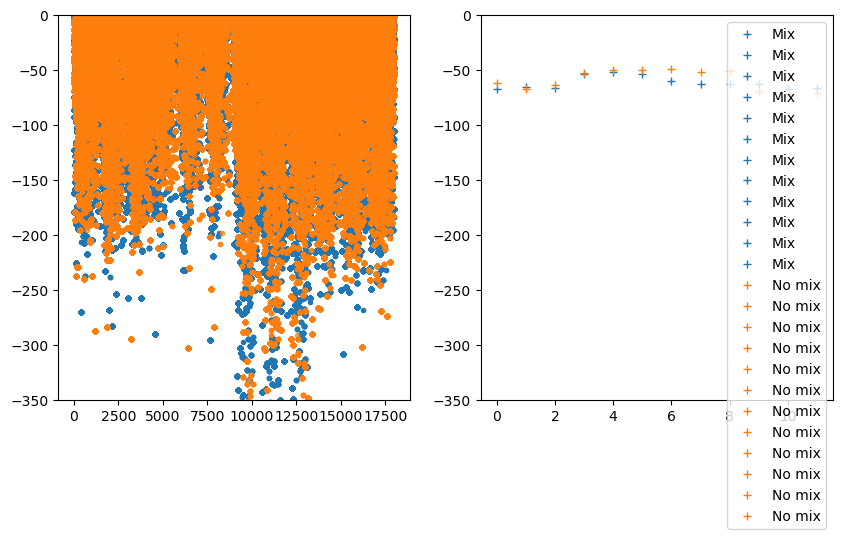

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

keep_depth_mix = np.zeros(12)
keep_depth_nomix = np.zeros(12)

name = 'PR Test mixing vs advection'
#daterange = [start+timedelta(days=i) for i in range(length)]
#fn =  name + '_'.join(d.strftime('%Y%m%d')+'_2L' for d in [start, start+duration]) + '.zarr'
for ii, fn in enumerate(sorted(glob.glob(os.path.join(path['out'], name + '*_[123]L*')))):
    print (fn)
    data = xr.open_zarr(fn)
    axs[0].plot(range(ii*1500, 1500*(1+ii)), (-data.z[:,-1]*data.fact[:,-1]).where(data.lat < 48.92), '.', c='tab:blue')
    axs[1].plot(ii, np.nanmean((-data.z[:,-1]*data.fact[:,-1]).where(data.lat < 48.92)), '+', c='tab:blue', label='Mix')
    keep_depth_mix[ii] = np.nanmean((-data.z[:,-1]*data.fact[:,-1]).where(data.lat < 48.92))
    data.close()

name = 'PR Test only advection '
for ii, fn in enumerate(sorted(glob.glob(os.path.join(path['out'], name + '*_[123]L*')))):
    data = xr.open_zarr(fn)
    axs[0].plot(range(ii*1500, 1500*(1+ii)), (-data.z[:,-1]*data.fact[:,-1]).where(data.lat < 48.92), '.', c='tab:orange', alpha=0.7)
    axs[1].plot(ii, np.nanmean((-data.z[:,-1]*data.fact[:,-1]).where(data.lat < 48.92)), '+', c='tab:orange', label='No mix')
    keep_depth_nomix[ii] = np.nanmean((-data.z[:,-1]*data.fact[:,-1]).where(data.lat < 48.92))
    data.close()

axs[1].legend()
for ax in axs:
    ax.set_ylim(-350, 0)



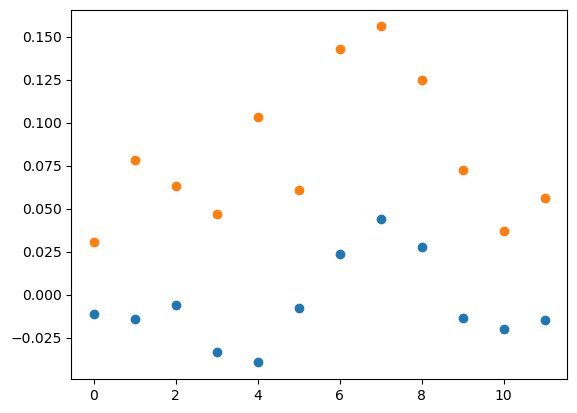

In [11]:
# Difference in Latitudes and Longitudes
plt.plot(keep_mix - keep_nomix, 'o')
plt.plot(lon_mix - lon_nomix, 'o');

In [13]:
# Stats on Latitudes
done = 12
print ((keep_mix[:done] - keep_nomix[:done]).max(), (keep_mix[:done] - keep_nomix[:done]).min())
thediff = (keep_mix[:done] - keep_nomix[:done]).mean()
thediff

0.04374906928390487 -0.03949780703354122


-0.005457673313091623

In [14]:
scipy.stats.ttest_1samp(keep_mix[:done] - keep_nomix[:done], 0)

TtestResult(statistic=-0.7623343693463001, pvalue=0.4618944854808328, df=11)

So not statistically different from zero.  The nomix moves slower.

In [15]:
thediff / (0.5* (-keep_mix[:done].mean() - keep_nomix[:done].mean() + 48.88177 + 48.9709))

-0.025793950100198717

In [16]:
print (keep_mix[:done].mean())

48.71201882244022


In [17]:
# Stats on Longitudes
scipy.stats.ttest_1samp(lon_mix[:done] - lon_nomix[:done], 0)


TtestResult(statistic=6.758504959857829, pvalue=3.121728726490687e-05, df=11)

So statistically different from zero.  The mix is further east.

In [18]:
print ((lon_mix[:done] - lon_nomix[:done]).max(), (lon_mix[:done] - lon_nomix[:done]).min())
londiff = (lon_mix[:done] - lon_nomix[:done]).mean()
print (londiff,  max_lon[:done].mean(), -lon_mix[:done].mean(), - lon_nomix[:done].mean()  )
print ((0.5* (-lon_mix[:done].mean() - lon_nomix[:done].mean() + 2*max_lon[:done].mean())))
print (0.5 *(2*max_lon[:done].mean() + 123.32755 + 123.083115 ))
londiff / (0.5* (-lon_mix[:done].mean() - lon_nomix[:done].mean() + 2*max_lon[:done].mean())
          + (2*max_lon[:done].mean() + 123.32755 + 123.083115 ))

0.15588490578393532 0.03050308013766312
0.08098158547447198 -123.10357228686793 123.15890028110817 123.23988186658266
0.09581878697748891
0.10176021313207428


0.27053450364052606

Isn't really including the full distance the cloud of particles is traveling.  Without an accurate estimate of that distance the denominator is wrong.  
So we have a curve: out to the east (maximum longitude) and back to the west.  So we include the longitude out to the east and back to the west and add it to the change in latitude.

In [19]:
# Calculate the distance
# longitude to max lon
part1 = 0.5 * (max_lon_nomix[:done].mean() + max_lon[:done].mean() + 123.32755 + 123.083115 )
# longitude from max lon
part3 = 0.5* (-lon_mix[:done].mean() - lon_nomix[:done].mean() 
              + max_lon_nomix[:done].mean() +max_lon[:done].mean())
# latitude 
part2 = (0.5* (-keep_mix[:done].mean() - keep_nomix[:done].mean() + 48.88177 + 48.9709))
# and convert latitude to longitude
part2 = part2 / np.cos(np.pi * 48.7 / 180.)
print (part1, part2, part3)
distance = part1 + part2 + part3
print (londiff/distance)
              

0.08803392484322359 0.32058606996695055 0.08209249868863822
0.1650285789486792


Still a problem, as the distance the mix particles arc and the distance the nomix particles arc is different, so its not good to average each piece between the mix and nomix.  Do each separately; then the mean.

In [20]:
# No mix distance
part1 = 0.5 * (2*max_lon_nomix[:done].mean() + 123.32755 + 123.083115 )
# longitude from max lon
part3 = 0.5* (-2*lon_nomix[:done].mean() 
              + 2*max_lon_nomix[:done].mean())
# latitude 
part2 = (0.5* (- 2*keep_nomix[:done].mean() + 48.88177 + 48.9709))
# and convert latitude to longitude
part2 = part2 / np.cos(np.pi * 48.7 / 180.)
print (part1, part2, part3)
distance_nm = part1 + part2 + part3
distance_nm

0.07430763655437289 0.31645147942116886 0.1088570031370324


0.49961611911257414

In [21]:
# Mix distance
part1 = 0.5 * (2*max_lon[:done].mean() + 123.32755 + 123.083115 )
# longitude from max lon
part3 = 0.5* (-2*lon_mix[:done].mean() 
              + 2*max_lon[:done].mean())
# latitude 
part2 = (0.5* (- 2*keep_mix[:done].mean() + 48.88177 + 48.9709))
# and convert latitude to longitude
part2 = part2 / np.cos(np.pi * 48.7 / 180.)
print (part1, part2, part3)
distance_mx = part1 + part2 + part3
distance_mx

0.10176021313207428 0.32472066051273224 0.05532799424024404


0.48180886788505056

In [22]:
(distance_nm - distance_mx)/(distance_nm + distance_mx)*2

0.03628856298431839

# So 3.6% different #

But should I consider the whole arc distance, or just the final difference in position?  Final distance in position is probably more sensible, except that we are still only partially through the estuary, elsewhere speed as calculated above will matter more.  Here I use the max lon from only the mix case.

0.1498380229129622


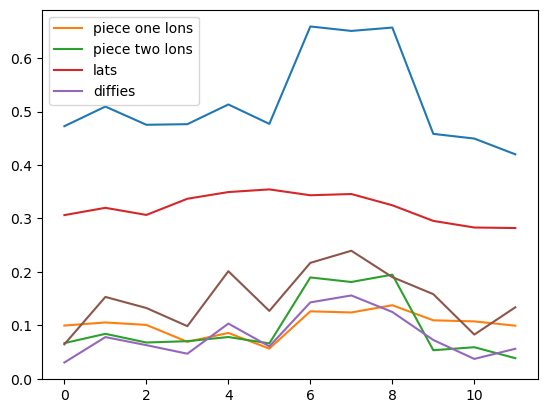

In [26]:
# One more look
part1 = 0.5 * (2*max_lon[:done] + 123.32755 + 123.083115 )
part3 = 0.5* (-lon_mix[:done] - lon_nomix[:done] + 2*max_lon[:done])
part2 = (0.5* (-keep_mix[:done] - keep_nomix[:done] + 48.88177 + 48.9709))
part2 = part2 / np.cos(np.pi * 48.7 / 180.)
distance = part1 + part2 + part3
plt.plot(distance)
plt.plot(part1, label='piece one lons')
plt.plot(part3, label='piece two lons')
plt.plot(part2, label='lats');
londiff = (lon_mix[:done] - lon_nomix[:done])
plt.plot(londiff, label='diffies')
speedratio = londiff/distance
plt.plot(speedratio)
plt.legend();
print (speedratio.mean())

Instead final difference in lon and use the average of the two paths (no much different at all)

In [27]:
print (londiff[:done].mean()/(distance_nm + distance_mx)*2)

0.1650285789486792


In [ ]:
print (max_lon[:done], 

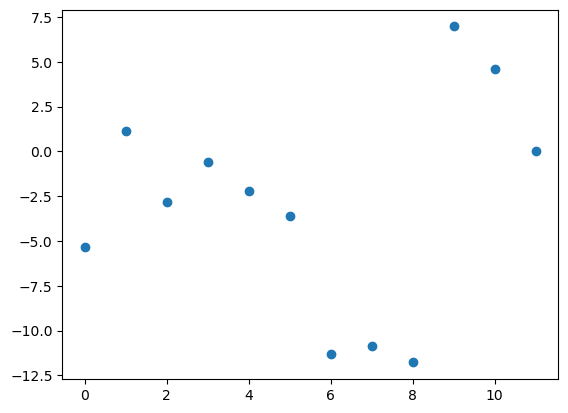

In [321]:
plt.plot(keep_depth_mix - keep_depth_nomix, 'o');

In [46]:
print ((keep_depth_mix[:done] - keep_depth_nomix[:done]).max(), (keep_depth_mix[:done] - keep_depth_nomix[:done]).min())
theddepth = (keep_depth_mix[:done] - keep_depth_nomix[:done]).mean()
theddepth

6.977267732263918 -11.782573956206285


-2.619604804202647

In [47]:
scipy.stats.ttest_1samp(keep_depth_mix[:done] - keep_depth_nomix[:done], 0)

TtestResult(statistic=-1.4223226051089146, pvalue=0.18266455859201372, df=11)

Now not significant. Mixed is deeper (as expected).  Note keep_depth is negative.

In [135]:
print (keep_depth_mix)

[-66.73818857 -65.48208438 -66.21202951 -53.1355582  -51.61920945
   0.           0.           0.           0.           0.
   0.           0.        ]


## Estimate Effective Kappa in the Mixing Region ##

In [221]:
print (max_lon)

[-122.69229974 -122.68003181 -122.63732133 -122.80806502 -122.7885156
 -122.83556681 -122.76209038 -122.68145639    0.            0.
    0.            0.        ]


So my latitude and longitude standard deviation increase from 0.1 to 0.2 or 0.3 in 15 days

In [1]:
stdev_m = 0.25 * 60 * 1861 # 60 nm  and 1 nm = 1861 m

So K = setdev**2/15days

In [3]:
Kappa = stdev_m**2 / (15 * 86400)
Kappa

601.2710069444445

Vertical about 30 m to 50 m in 60 hours


In [6]:
# kappa_v = 30**2 / (2* t1 * 3600)
# kappa_v = 65**2 / (2 *(t1 + 100) * 3600)
kappa = (65**2 - 30**2) / (2 * 100 * 3600)
kappa

0.004618055555555556

## 1.6*50*50/(24e-3)

In [ ]:
48.88177 -123.32755 48.9709 -123.083115